In [1]:
import pandas as pd
import spacy
import re
import seaborn as sns
sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from IPython.display import IFrame
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance

# Topic modelling with Topic-frequency, Inverse-document-frequency (TF-IDF)

While it's relatively easy to group words together, matters are less simple for documents. Nevertheless, we are usually far more interested in grouping documents together than we are words, especially when they all belong to a corpus. So an early problem that emerged in NLP centred on how we might do this. 

One solution proposed by Karen Spärck Jones in 1972 was TF-IDF scoring. This method is based in two ideas:

* We should 'punish' words that occur frequently in all the documents in our corpus
* We should 'reward' words that occur frequently in small numbers of documents in our corpus

The intuition behind these ideas is fairly simple. For a topic to be coherent, it will generally consist of a small number of concepts. As these concepts will expressed as words, we should expect these topic-related words to concentrate in the documents that belong to this topic. However, some words (like prepositions and common verbs) will appear in all documents. So if we can can create a word-document matrix that assigns a score to each word in each document, we can gain a numerical representation––a vector––of how each document in a corpus differs from every other one.

Once we have these vectors, we can then perform various operations (like clustering) upon them to discover how they might be grouped together. But how do we calculate them?

The TF-IDF score for a word is the product of two quantities: the term frequency, and the inverse document frequency.

$$TF\text{-}IDF (t, d, D) = tf(t,d)\times idf(t, D)$$

Where $t$ is a term, $d$ is a document, and $D$ is the corpus. Let's create a toy corpus to illustrate this.

$D$ = {{$d_1$: Atomic Burger makes a tasty burger}, {$d_2$: An atomic clock is accurate}, {$d_3$: Atomic weapons are destructive}}

First, let's look at how we might calculate $tf(t,d)$. This is the relative frequency of each term in each document. That is, it's the number of times a term $t_i$ occurs in a document $d$ divided by the total number of terms in the document:

$$tf(t,d) = \frac{f_{t_i,d}}{\sum\limits_{t\in d}f_{t,d}}$$

For example, in document $d_1$ 'burger' has a $tf(t,d)$ score of 0.333 because there are six words and it occurs twice. Every other word has a score of 0.16 because it only occurs once. Words that occur often are therefore 'rewarded' in this part of the calculation.

Now, let's look at $idf(t,D)$. This adjusts the $tf(t,d)$ score by capturing how often a word occurs across the entire corpus of documents. It is the logarithm of the number of documents in a corpus divided by the number of douments that contain the term in the corpus. 

$$idf(t,D) = \log{\frac{N}{|\{d\in D: t \in d\}|}}$$

What's happening here? If a term occurs in all documents, the formula outputs a value of 0, because the total number of documents divided by the number of dcouments containing the term is $\log(1)= 0$. If the term occurs in a smaller number of documents, the formula gives a larger number, with the largest number being given when the term only occurs in one document. For example, 'atomic' occurs in all documents, so the $idf(t,D)$ value for 'atomic' is 0. However, 'burger' occurs in only one document, so the value is $\log{\frac{3}{1}} = 1.09$. In this way, the $idf(t,D)$ 'punishes' words that are common and therefore not topic specific. 

The result is that by multiplying $tf(t,d)$ and $idf(t,D)$, we are able to capture the role played by a word in determining the topic of a document relative to a corpus. The $TF\text{-}IDF (t, d, D)$ representation of a document is a vector of the values taken by all the words in that document relative to all the words in the corpus (with a value of 0 being taken when a word does not appear in the document).


In [29]:
vectorizer = TfidfVectorizer(input = 'content', strip_accents = 'ascii', stop_words = 'english')

D = ['Atomic Burger makes a tasty burger', 'An atomic clock is accurate', 'Atomic weapons are destructive']

v = vectorizer.fit_transform(D)
v = v.todense().tolist()

d = pd.DataFrame(
    v,columns=vectorizer.get_feature_names_out())
d.index = ['d1', 'd2', 'd3']

In [34]:
d

accurate    atomic    burger     clock  destructive     makes     tasty  \
d1  0.000000  0.234400  0.793749  0.000000     0.000000  0.396875  0.396875   
d2  0.652491  0.385372  0.000000  0.652491     0.000000  0.000000  0.000000   
d3  0.000000  0.385372  0.000000  0.000000     0.652491  0.000000  0.000000   

     weapons  
d1  0.000000  
d2  0.000000  
d3  0.652491

In [31]:
distances = [[] for i in range(len(d))]

for i in range(len(d)):
    for j in range(len(d)):
        distances[i].append(distance.cosine(d.iloc[i], d.iloc[j]))
        
dist_df = pd.DataFrame(distances, columns = d.index, index = d.index)


<AxesSubplot: >

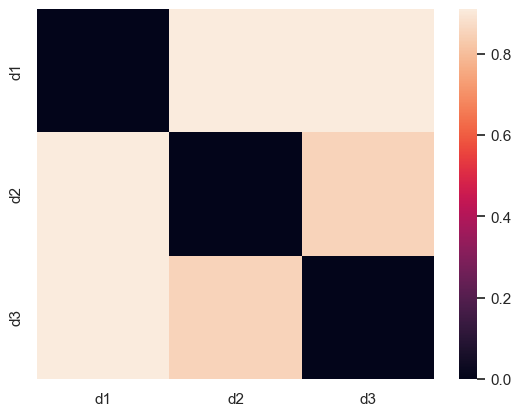

In [32]:
sns.heatmap(dist_df)

In [53]:
data = pd.read_excel('/Users/jamescarney/Downloads/ED_twitter_data.xlsx', index_col = 0)

data = data.drop_duplicates(subset = ['tweet']).reset_index(drop = True)

In [54]:
len(data)

3291

In [55]:
text = [i for i in data['tweet']]

In [57]:
vectors = vectorizer.fit_transform(text)

In [58]:
vectors = vectors.todense().tolist()

In [59]:
df = pd.DataFrame(
    vectors,columns=vectorizer.get_feature_names_out())

In [60]:

pca_1 = PCA(n_components = 3)
comps_1 = pca_1.fit_transform(df)
pc_df_1 = pd.DataFrame(data = comps_1, columns = ['PC'+str(i) for i in range(1, comps_1.shape[1]+1)])



In [61]:
clustering = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward').fit(df)

In [62]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df)

In [63]:
df_all = pd.concat([df, pc_df_1], axis = 1)
df_all['clusters_ag'] = [str(i) for i in clustering.labels_]
df_all['clusters_knn'] = [str(i) for i in kmeans.labels_]
df_all['tweet_text'] = data['tweet']
df_all['attitude'] = data['attitude']
df_all['likes'] = [(i+1)*100 for i in data['nlikes']]

In [ ]:
fig = px.scatter_3d(df_all, x='PC1', y='PC2', z='PC3',
              color='clusters_ag', hover_data = ['tweet_text', 'attitude'])

fig.update_traces(marker=dict(size = 5, line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show('notebook')

In [83]:
d = df_all.loc[df_all['clusters_ag'] == '1']

In [84]:
d_t = [i for i in d['tweet_text']]

In [87]:
len(d_t)

204

In [89]:
d_t

['It is never to late to choose #Recovery and it is definitely worth it #EatingDisorders #Anorexia #Bulimia #BingeEating #MentalHealth  http://www.anorexiabulimiacare.org.uk/recovery/inspiration\xa0…',
 'Give Up versus Never Give Up?  https://www.marinotherapycentre.com/give-versus-never-give/\xa0… via @marie_at_marino #EatingDisorders #Recovery #Anorexia #Bulimia #EmotionalEating #hope #Motivation #MentalHealth',
 'From The Recovered To Those Who Are Recovering xxxx  https://www.marinotherapycentre.com/from-the-recovered-to-those-who-are-recovering-xxxx/\xa0… via @marie_at_marino #EatingDisorders #Recovery #Hope #Anorexia #bulimia #EmotionalEating #MentalHealth #motivation',
 '7th October Funny Parts of Recovery  https://www.marinotherapycentre.com/7th-october-funny-parts-recovery/\xa0… via @marie_at_marino #Recovery #Monday #DailyTips #EatingDisorders #Anorexia #Bulimia #EmotionalEating #MentalHealth',
 "6th October Today's Recovery Tip: Tree Ring  https://www.marinotherapycentre.com

In [17]:
gov = pd.read_pickle('/Users/jamescarney/Dropbox/textureAI/client_projects/UK_gov_corona/data/MARCH/19_MAR_window.pkl')

In [20]:
gov = gov.dropna(subset = 'tweet')

In [22]:
gov = gov.head(12000)

In [23]:
def identity_tokenizer(text):
    return text

In [24]:
tweets = [i for i in gov['proc']]



In [8]:
vectorizer_ = TfidfVectorizer(input = 'content', lowercase = False, tokenizer = identity_tokenizer)

In [9]:
vectors_ = vectorizer_.fit_transform(tweets)

/Users/jamescarney/opt/anaconda3/envs/NLP/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
vectors_ = vectors_.todense().tolist()

In [11]:
df_ = pd.DataFrame(
    vectors_, columns=vectorizer_.get_feature_names_out())

In [12]:
pca_1 = PCA(n_components = 3)
comps_1 = pca_1.fit_transform(df_)
pc_df_1 = pd.DataFrame(data = comps_1, columns = ['PC'+str(i) for i in range(1, comps_1.shape[1]+1)])


In [13]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df_)

In [14]:
df_ = pd.concat([df_, pc_df_1], axis = 1)
df_['clusters_knn'] = [str(i) for i in kmeans.labels_]
df_['tweet_text'] = gov['tweet']

In [25]:
df_.iloc[0]

"prime                                                                             0.0
#calmyourself&stiffenyourbackbone                                                  0.0
#coronavirus                                                                       0.0
#healthystaffhappystaff                                                            0.0
#karma                                                                             0.0
                                                           ...                        
PC1                                                                           0.092273
PC2                                                                           0.186138
PC3                                                                           -0.04117
clusters_knn                                                                         0
tweet_text                           Boris Johnson hints at lockdown for London htt...
Name: 0, Length: 14106, dtype: object

In [16]:
fig = px.scatter_3d(df_, x='PC1', y='PC2', z='PC3',
              color='clusters_knn', hover_data = ['tweet_text'])

fig.update_traces(marker=dict(size = 5, line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show('notebook')